In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tarfile
import os

data_base_path = os.path.join('data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [3]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.covariance import LedoitWolf
import seaborn as sns

In [4]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

In [5]:
print(train_features.shape)
train_labels.reshape(-1,1).shape

torch.Size([878, 768])


(878, 1)

In [6]:
train_data = np.hstack((train_features,train_labels.reshape(-1,1)))
test_data = np.hstack((train_features,train_labels.reshape(-1,1)))
test_features[test_labels==1].numpy().shape

(93, 768)

In [7]:
#np.cov(test_features[])
x = np.array([[0,1,0],[0,1,0]])
cov = LedoitWolf().fit(x)
#cov.covariance_
mu = np.mean(x,axis=0)
np.dot(mu,cov.covariance_)

array([0., 0., 0.])

### 1.1

In [8]:
from numpy import linalg

def mahalanobis_dist(x,inv,mu):
    output = np.dot(inv,x-mu)
    output = np.dot(x-mu, output)
    return np.sqrt(output)

class mahalanobis_classifier():
    def __init__(self):
        self.covariances = []
        self.inverses = []
        self.means = []
        self.n_classes = 2
        self.labels = None
        
    def fit(self,X_train,y_train):
        self.n_classes = len(np.unique(y_train))
        self.labels = np.unique(y_train)
        for i in range(self.n_classes):
            data = X_train[y_train==self.labels[i]]
            #print(data)
            cov = LedoitWolf().fit(data).covariance_
            mu = np.mean(data,axis=0)
            inv = linalg.inv(cov)
            self.covariances.append(cov)
            self.means.append(mu)
            self.inverses.append(inv)
        
    def predict(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(self.labels[np.argmin(distances)])
        return np.array(output)
    
    def get_min_distances(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(min(distances))
        return np.array(output)
    
    def get_distances(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(min(distances))
        return np.array(output)

In [9]:
X_train = train_features.numpy()
y_train = train_labels
X_test = test_features.numpy()
y_test = test_labels

clf = mahalanobis_classifier()
clf.fit(X_train,y_train)
y_hat = clf.predict(X_test)

print(np.mean(y_hat==y_test))

0.978494623655914


### 1.2

In [10]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

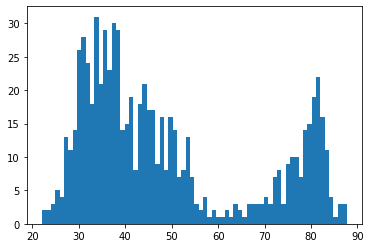

In [11]:
X_test_new = test_features_w_ood.numpy()
y_test_new = test_labels_w_ood

distances = clf.get_min_distances(X_test_new)
plt.hist(distances,bins=70)
plt.show()

In [12]:
train_distances = clf.get_min_distances(X_train)
#thresh = np.max(train_distances)

thresh = 31
#X_test_id = X_test[distances<thresh]
#y_hat_new = np.append(clf.predict(X_test_id),)
y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if distances[i]>thresh:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print("portion of ",np.sum(y_test_new==-1)/len(y_test_new))
print('new_accuracy',np.mean(y_hat_new==y_test_new))

portion of  0.75
new_accuracy 0.793010752688172


In [13]:
train_distances = clf.min_distances(X_train)
plt.hist(train_distances,bins=20)
plt.show()
thresh = np.max(train_distances)
print(thresh)

AttributeError: 'mahalanobis_classifier' object has no attribute 'min_distances'

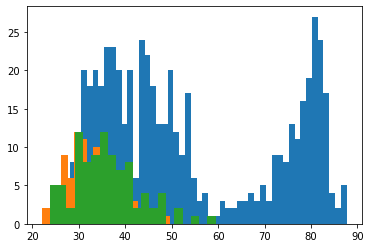

In [14]:
#Task 3

index_0 = (y_test_new==0)
distances_0 = distances[y_test_new==0]
distances_1 = distances[y_test_new==1]
distances_ood = distances[y_test_new==-1]
plt.hist(distances_ood,bins=50)
plt.hist(distances_0,bins=20)
plt.hist(distances_1,bins=20)
plt.show()

In [15]:
#Task 4

thresh_ood_5 = np.sort(distances_ood)[int(len(distances_ood)*0.05)]
print("0.05 quantile of OOD samples:",thresh_ood_5)

#Task 5

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if distances[i]>thresh_ood_5:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('new_accuracy',np.mean(y_hat_new==y_test_new))
print('class 0 filtered out:',sum(distances_0>thresh_ood_5)/len(distances_0))
print('class 1 filtered out:',sum(distances_1>thresh_ood_5)/len(distances_1))

0.05 quantile of OOD samples: 30.65177
new_accuracy 0.7903225806451613
class 0 filtered out: 0.6129032258064516
class 1 filtered out: 0.7634408602150538


### 1.3

In [16]:
#Task 1

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

class KNNClassifier(KNeighborsClassifier):
    def ood_metric(self,X,k_neighbors=None,p=2):
        if k_neighbors==None:
            k_neighbors=self.n_neighbors            
        neigh_distances = self.kneighbors(X,k_neighbors,return_distance=True)[0]
        neigh_distances = np.array(neigh_distances)
        output = []
        for d in neigh_distances:
            if p==0:
                out = np.max(d)
            elif p=='infty':
                out = np.min(d)
            else:
                out = np.sum(d**p)**(1/p)
            output.append(out)
        return np.array(output)
    def predict_ood(self,X,metrics,threshold,ood_label=-1):
        output = self.predict(X)
        for i in range(len(X)):
            if metrics[i]>threshold:
                output=ood_label
        return output
            
knn = KNNClassifier(n_neighbors=5,weights='distance') # brute knn
knn.fit(X_train,y_train)
y_hat_brute = knn.predict(X_test)
print(np.mean(y_hat_brute==y_test))

0.9946236559139785


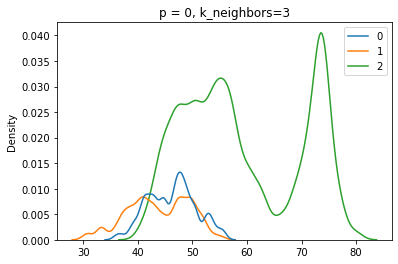

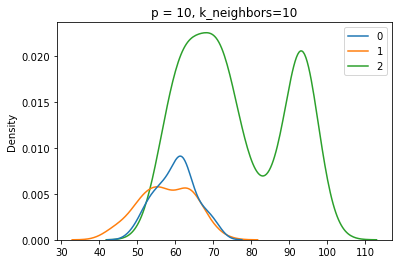

In [17]:
p = 0
k_neighbors = 3
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
plt.figure()
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=0.4)
plt.title(f"p = {p}, k_neighbors={k_neighbors}")
plt.show()

p = 10
k_neighbors = 10
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
plt.figure()
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=1)
plt.title(f"p = {p}, k_neighbors={k_neighbors}")
plt.show()

In [18]:
p = 0
k_neighbors = 3
metrics = knn.ood_metric(X_test_new,k_neighbors=k_neighbors,p=p)
y_hat_new_knn = knn.predict_ood(X_test_new,metrics,120)
print(np.mean(y_hat_new_knn==y_test_new))

0.24865591397849462


We also try to do outlier detection using LOcalOutlierFactor method available in sklearn. One iportant input to it is the minimum number of points that are required to define a cluster, call it minpts.

THis method calculates a 'k-distance' $\alpha$ such that at least k objects are in the closed ball of radius $\alpha$ and ak least k-1 are in the open ball of radius $\alpha$. Next this distance is combined with the distances within the 'k-nearest' neighbours of the point by taking the maximum of this and the maximum distance between points in its vicinity to get the reachability distance. After this, we take the average of the reciprocals of the rachability distance for the 'k-nearest' neighbours of this point to get the local reachability density. This is used to define the lcal outlier factor as in the name by taking the average proportion of local reachability distance normalised to the lrd of the given point for the min-pts nearest neighbours.

Next, a threshold is chosed to give predictions regarding OOD-characteristic of the points.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=3,novelty=True)
lof.fit(X_train,y_train)

goodness_score = lof.decision_function(X_test_new)
goodness_0 = lof.decision_function(X_test_new[y_test_new==0])
goodness_1 = lof.decision_function(X_test_new[y_test_new==1])
goodness_ood = lof.decision_function(X_test_new[y_test_new==-1])

plt.figure()
sns.kdeplot(data=[goodness_0,goodness_1,goodness_ood],bw_adjust=0.4)
plt.show()

thresh_ood_95 = np.sort(goodness_ood)[int(len(goodness_ood)*0.95)]
print("0.05 quantile of OOD samples:",thresh_ood_5)

#Task 5

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if goodness_score[i]<thresh_ood_95:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('new_accuracy',np.mean(y_hat_new==y_test_new))
print('class 0 filtered out:',sum(goodness_0>thresh_ood_95)/len(goodness_0))
print('class 1 filtered out:',sum(goodness_1>thresh_ood_95)/len(goodness_1))

## 2

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [6]:
data_base_path = os.path.join('data')
data_folder = 'lab-03-data'

tar = tarfile.open(os.path.join(data_base_path, data_folder + '.tar.gz'), 'r:gz')
tar.extractall()
tar.close()

In [7]:
features_path = 'lab-03-data/part2/sipakmed_clean_embeddings.pth'

### 2.1

In [8]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.features)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

In [9]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path=features_path, phase='train')
val_dataset = Sipakmed(features_path=features_path, phase='val')
test_dataset = Sipakmed(features_path=features_path, phase='test')

In [116]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

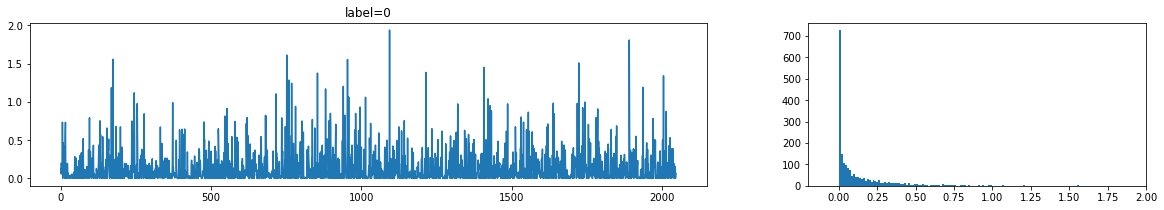

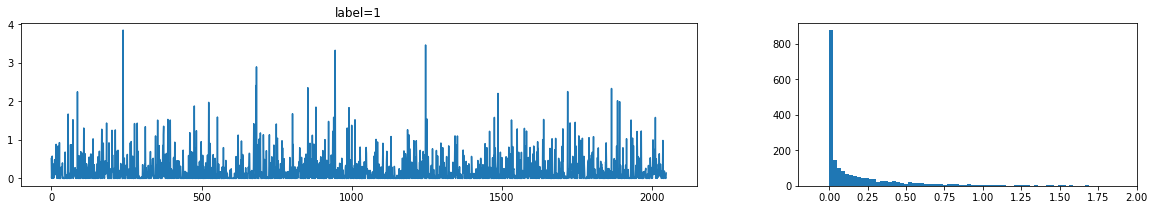

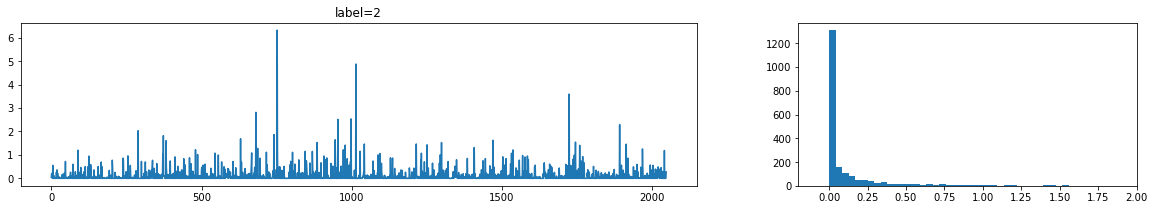

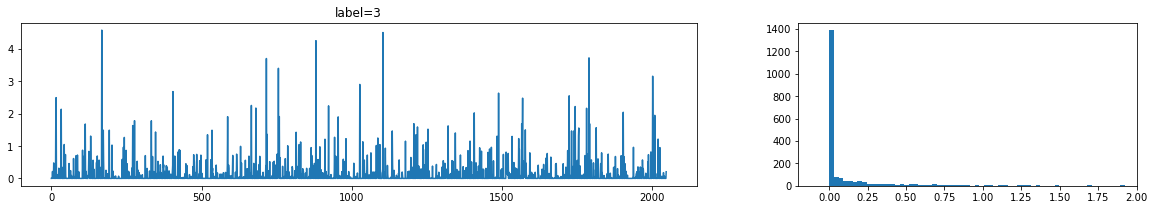

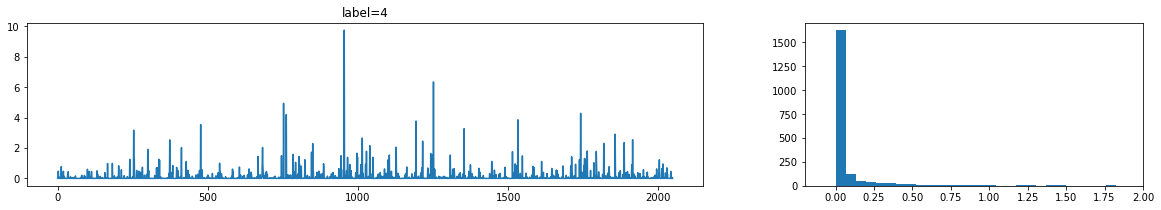

In [11]:
np.random.seed(42)

for label in range(5):
    n = (train_dataset.labels==label).sum()
    rand_ind = np.random.randint(n)
    label_features = train_dataset.features[train_dataset.labels==label]
    datapoint = label_features[rand_ind]
    fig,axs = plt.subplots(ncols=2,figsize=(20,3),gridspec_kw={'width_ratios': [2, 1]})
    axs[0].set_title(f'label={label}')
    axs[0].plot(datapoint)
    axs[1].set_xlim(-0.2,2)
    axs[1].hist(datapoint.numpy(),bins=150)
sample_0 = train_dataset[train_dataset.labels==0][0]

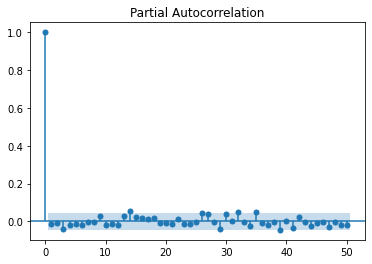

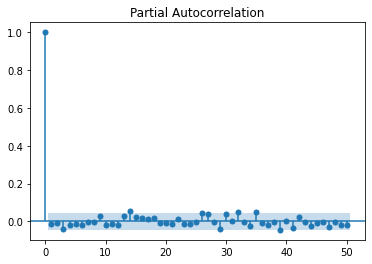

In [123]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(datapoint,lags=50)

In [115]:
train_dataset[0]

(tensor([0.3188, 0.0242, 0.2170,  ..., 0.0000, 0.0000, 0.0316]),
 tensor(0),
 'sipakmed_clean/im_Superficial-Intermediate/057_09.jpg')

### 2.2

In [253]:
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self,input_size,conv_sizes,pool_sizes,drop_p=0.25):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[0])
        self.pool1 = nn.MaxPool1d(pool_sizes[0])
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[1])
        self.pool2 = nn.MaxPool1d(pool_sizes[1])
        #self.conv3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[2])
        #self.pool3 = nn.MaxPool1d(pool_sizes[2])
        self.fc_input_size = self.get_fc_input_size(torch.randn(1,input_size))
        self.fc1 = nn.Linear(self.fc_input_size, 5)
        #self.fc2 = nn.Linear(20, 5)
        self.dropout = nn.Dropout(p=drop_p)
        self.sigmoid = nn.Sigmoid()
    
    def get_fc_input_size(self,x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        return output.shape[-1]
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        output = self.relu(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        #output = self.relu(output)
        
        output = self.fc1(output)
        #output = self.relu(output)
        #output = self.fc2(output)
        output = self.dropout(output)
        #output = self.sigmoid(output)
        return output

torch.Size([1, 5])


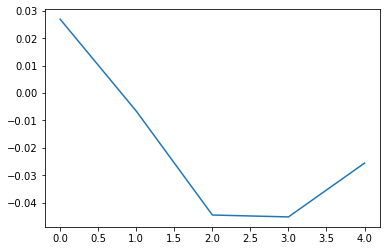

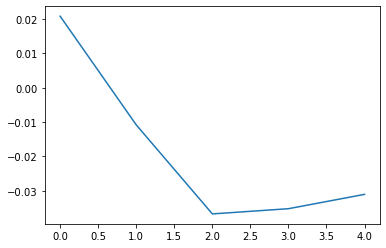

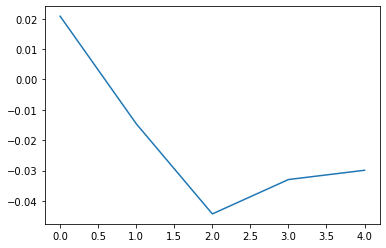

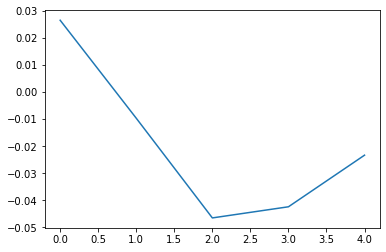

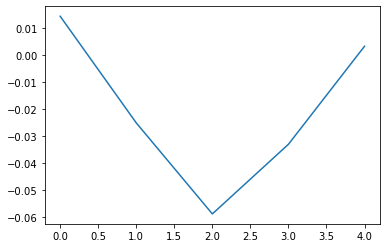

In [115]:
model = MyModel(input_size=2048,conv_sizes=[13,7],pool_sizes=[3,5])
model.eval()
np.random.seed(0)
for label in range(5):
    n = (train_dataset.labels==label).sum()
    rand_ind = np.random.randint(n)
    label_features = train_dataset.features[train_dataset.labels==label]
    datapoint = label_features[rand_ind]
    inp = datapoint.unsqueeze(0)
    plt.figure()
    plt.plot(model(inp).detach().numpy()[0])
print(model(inp).shape)

In [295]:
model = MyModel(input_size=2048,conv_sizes=[21,15],pool_sizes=[3,2],drop_p=0.2)

lr = 0.003
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6)


loaders = {"train": train_loader, "val": val_loader}

activation = nn.Sigmoid()

#-------------------------------------------------------------
l1_lambda = 0.0001
l2_lambda = 0.001

max_epochs = 1500
accuracy = {"train": [], "val": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch, path in dataloader:
            if k == "train":
                model.train()
                model.zero_grad()
                outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
                    x_batch.shape[0], 5)
            else:
                model.eval()
                outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
                    x_batch.shape[0], 5)
            preds = torch.argmax(activation(outp), dim=1).flatten()
            correct = (preds == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += y_batch.shape[0]
            if k == "train":
                loss = criterion(outp, y_batch)
                l1_reg, l2_reg = torch.tensor(0.), torch.tensor(0.)
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2)
                    l1_reg += torch.norm(param, p=1)
                #loss += l2_lambda * l2_reg 
                loss += l1_lambda * l1_reg
                loss.backward()
                optimizer.step()
                #scheduler.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    scheduler.step()

Epoch: 1
Loader: train. Accuracy: 0.4980217606330366
Loader: val. Accuracy: 0.7796442687747036
Epoch: 2
Loader: train. Accuracy: 0.7601384767556875
Loader: val. Accuracy: 0.8310276679841897
Epoch: 3
Loader: train. Accuracy: 0.8180019782393669
Loader: val. Accuracy: 0.8725296442687747
Epoch: 4
Loader: train. Accuracy: 0.8461918892185954
Loader: val. Accuracy: 0.8764822134387352
Epoch: 5
Loader: train. Accuracy: 0.8452027695351138
Loader: val. Accuracy: 0.8685770750988142
Epoch: 6
Loader: train. Accuracy: 0.8536102868447082
Loader: val. Accuracy: 0.8824110671936759
Epoch: 7
Loader: train. Accuracy: 0.8600395647873392
Loader: val. Accuracy: 0.892292490118577
Epoch: 8
Loader: train. Accuracy: 0.8545994065281899
Loader: val. Accuracy: 0.8883399209486166
Epoch: 9
Loader: train. Accuracy: 0.8719090009891197
Loader: val. Accuracy: 0.8873517786561265
Epoch: 10
Loader: train. Accuracy: 0.8728981206726014
Loader: val. Accuracy: 0.8843873517786561
Epoch: 11
Loader: train. Accuracy: 0.8615232443125

Epoch: 87
Loader: train. Accuracy: 0.9124629080118695
Loader: val. Accuracy: 0.8982213438735178
Epoch: 88
Loader: train. Accuracy: 0.9129574678536103
Loader: val. Accuracy: 0.900197628458498
Epoch: 89
Loader: train. Accuracy: 0.917408506429278
Loader: val. Accuracy: 0.900197628458498
Epoch: 90
Loader: train. Accuracy: 0.9119683481701286
Loader: val. Accuracy: 0.8962450592885376
Epoch: 91
Loader: train. Accuracy: 0.9282888229475766
Loader: val. Accuracy: 0.9021739130434783
Epoch: 92
Loader: train. Accuracy: 0.9119683481701286
Loader: val. Accuracy: 0.9021739130434783
Epoch: 93
Loader: train. Accuracy: 0.917408506429278
Loader: val. Accuracy: 0.9041501976284585
Epoch: 94
Loader: train. Accuracy: 0.9149357072205737
Loader: val. Accuracy: 0.8982213438735178
Epoch: 95
Loader: train. Accuracy: 0.9144411473788329
Loader: val. Accuracy: 0.9021739130434783
Epoch: 96
Loader: train. Accuracy: 0.9159248269040554
Loader: val. Accuracy: 0.8992094861660079
Epoch: 97
Loader: train. Accuracy: 0.9149357

KeyboardInterrupt: 

In [285]:
print(model.get_fc_input_size(torch.randn(1,2048)))

331


0.9140316205533597


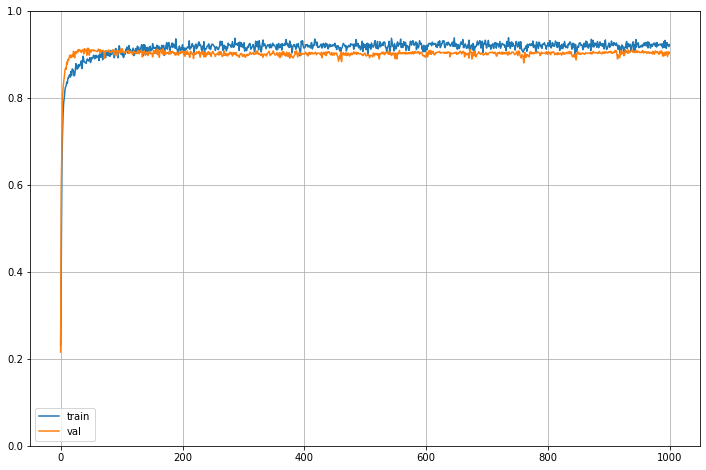

In [278]:
plt.figure(figsize=(12,8))
plt.plot(accuracy['train'],label='train')
plt.plot(accuracy['val'],label='val')
plt.ylim(0, 1)
plt.grid()
plt.legend()
print(max(accuracy['val']))